##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Better performance with the tf.data API

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/guide/data_performance"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/guide/data_performance.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/guide/data_performance.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/guide/data_performance.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Overview

GPUs and TPUs can radically reduce the time required to execute a single training step.
Achieving peak performance requires an efficient input pipeline that delivers data for the next step before the current step has finished.
The `tf.data` API helps to build flexible and efficient input pipelines.
This document demonstrates how to use the `tf.data` API to build highly performant TensorFlow input pipelines.

Before you continue, read the "[Build TensorFlow input pipelines](./data.ipynb)" guide, to learn how to use the `tf.data` API.

## Resources

* [Build TensorFlow input pipelines](https://www.tensorflow.org/guide/data)
* `tf.data.Dataset` API

## Setup

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()

import time

Throughout this guide, you will iterate across a dataset and measure the performance.
Making reproducible performance benchmarks can be difficult, different factors impacting it: the current CPU load, the network traffic, some complex mechanism like cache, etc.
Hence, to provide reproducible examples, build an artificial dataset.

### The dataset

Define a class inheriting from `tf.data.Dataset` called `ArtificialDataset`.
This dataset:
- generates `num_samples` samples (default is 3)
- sleeps for some time before the first item to simulate opening a file
- sleeps for some time before producing each item to simulate reading data from a file

In [2]:
class ArtificialDataset(tf.data.Dataset):
    def _generator(num_samples):
        # Opening the file
        time.sleep(0.03)
        
        for sample_idx in range(num_samples):
            # Reading a data (line, record) from the file
            time.sleep(0.015)
            
            yield (sample_idx,)
    
    def __new__(cls, num_samples=3, *args):
        return tf.data.Dataset.from_generator(
            cls._generator,
            output_types=tf.dtypes.int64,
            output_shapes=(1,),
            args=(num_samples,)
        )

This dataset is similar to the `tf.data.Dataset.range` one, adding a fixed delay at the beginning and between each sample.

### The iteration loop

Write a dummy training loop that measures how long it takes to iterate over a dataset.
Training time is simulated.

In [3]:
def iterate(ds, num_epochs=2):
    start_time = time.perf_counter()
    for epoch_num in range(num_epochs):
        for sample in ds:
            # Simulate training time
            time.sleep(0.01)
    tf.print("Execution time:", time.perf_counter() - start_time)

## Optimize performance

To exhibit how performance can be optimized, you will improve the performance of the `ArtificialDataset`.

### The naive approach

Start with a naive pipeline using no tricks, iterating over the dataset as-is.

In [4]:
iterate(ArtificialDataset())

Execution time: 0.26023280799927306


Under the hood, this is how your execution time was spent:

![Naive](./naive.svg)

You can see that performing a training step involves:
- opening a file if it hasn't been opened yet,
- fetching a data entry from the file,
- using the data for training.

However, in a naive synchronous implementation like here, while your pipeline is fetching the data, your model is sitting idle. 
Conversely, while your model is training, the input pipeline is sitting idle.
The training step time is thus the sum of all, loading, fetching and training time.

The next sections build on this input pipeline, illustrating best practices for designing performant TensorFlow input pipelines.

### Prefetching

Prefetching overlaps the preprocessing and model execution of a training step.
While the model is executing training step `s`, the input pipeline is fetching the data for step `s+1`.
Doing so reduces the step time to the maximum (as opposed to the sum) of the training and the time it takes to extract and transform the data.

The `tf.data` API provides the `tf.data.Dataset.prefetch` transformation.
It can be used to decouple the time when data is produced from the time when data is consumed.
In particular, the transformation uses a background thread and an internal buffer to prefetch elements from the input dataset ahead of the time they are requested.
The number of elements to prefetch should be equal to (or possibly greater than) the number of batches consumed by a single training step.
You could either manually tune this value, or set it to `tf.data.experimental.AUTOTUNE` which will prompt the
`tf.data` runtime to tune the value dynamically at runtime.

Note that the prefetch transformation provides benefits any time there is an opportunity to overlap the work of a "producer" with the work of a "consumer."

In [6]:
iterate(
    ArtificialDataset()
    .prefetch(tf.data.experimental.AUTOTUNE)
)

Execution time: 0.22707201799858012


![Prefetched](./prefetched.svg)

This time you can see that while the training step is running for sample 0, the input pipeline is fetching the data for the sample 1, and so on.

### Parallelize data extraction

In a real-world setting, the input data may be stored remotely (for example, GCS or HDFS).
A dataset pipeline that works well when reading data locally might become bottlenecked on I/O when reading data remotely because of the following differences between local and remote storage:

*   **Time-to-first-byte:** Reading the first byte of a file from remote storage can take orders of magnitude longer than from local storage.
*   **Read throughput:** While remote storage typically offers large aggregate bandwidth, reading a single file might only be able to utilize a small fraction of this bandwidth.

In addition, once the raw bytes are read into memory, it may also be necessary to deserialize and/or decrypt the data (e.g. [protobuf](https://developers.google.com/protocol-buffers/)), which requires additional computation.
This overhead is present irrespective of whether the data is stored locally or remotely, but can be worse in the remote case if data is not prefetched effectively.

To mitigate the impact of the various data extraction overheads, the `tf.data.Dataset.interleave` transformation can be used to parallelize the data loading step, interleaving the contents of other datasets (such as data file
readers).
The number of datasets to overlap can be specified by the `cycle_length` argument, while the level of parallelism can be specified by the `num_parallel_calls` argument. Similar to the `prefetch` transformation, the `interleave` transformation supports `tf.data.experimental.AUTOTUNE` which will delegate the decision about what level of parallelism to use to the `tf.data` runtime.

#### Sequential interleave

For the second example, use the `tf.data.Dataset.interleave` method with its default values.

In [6]:
iterate(
    tf.data.Dataset.range(2)
    .interleave(ArtificialDataset)
)

Execution time: 0.22498885300046823


![Sequential interleave](./sequential_interleave.svg)

This plot allows to exhibit the behavior of the `interleave` transformation, fetching samples alternatively from the two datasets available. However, no performance improvement is perceptible.

#### Parallel interleave

Now use the `num_parallel_calls` argument of the `interleave` method.
This loads multiple datasets in parallel, reducing the time waiting for files to be opened.

In [5]:
iterate(
    tf.data.Dataset.range(2)
    .interleave(
        ArtificialDataset,
        num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
)

Execution time: 0.15551930999936303


![Parallel interleave](./parallel_interleave.svg)

This time, the reading of the two datasets is parallelized, reducing the global data processing time.

### Parallelize data transformation

When preparing data, input elements may need to be pre-processed.
To this end, the `tf.data` API offers the `tf.data.Dataset.map` transformation, which applies a user-defined function to each element of the input dataset.
Because input elements are independent of one another, the pre-processing can be parallelized across multiple CPU cores.
To make this possible, similarly to the `prefetch` and `interleave` transformations, the `map` transformation provides the `num_parallel_calls` argument to specify the level of parallelism.

Choosing the best value for the `num_parallel_calls` argument depends on your hardware, characteristics of your training data (such as its size and shape), the cost of your map function, and what other processing is happening on the CPU at the same time.
A simple heuristic is to use the number of available CPU cores.
However, as for the `prefetch` and `interleave` transformation, the `map` transformation supports `tf.data.experimental.AUTOTUNE` which will delegate the decision about what level of parallelism to use to the `tf.data` runtime.

In [8]:
def mapped_function(s):
    # Do some hard pre-processing
    x = 0
    for _ in range(1000):
        x = -x
    return s

#### Sequential mapping

Start by using the `map` transformation without parallelism as a baseline example.

In [11]:
iterate(
    ArtificialDataset()
    .map(mapped_function)
)

Execution time: 0.25554579900017416


![Sequential mapping](./naive_map.svg)

As for the [naive approach](#The-naive-approach), here the times spent for loading, fetching, pre-processing (mapping) and training steps sum together for a single iteration.

#### Parallel mapping

Now, use the same pre-processing function but apply it in parallel on multiple samples.

In [10]:
iterate(
    ArtificialDataset()
    .map(
        mapped_function,
        num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
)

Execution time: 0.22724438600016583


![Parallel mapping](./parallel_map.svg)

Now, you can see on the plot that the pre-processing steps overlap, reducing the overall time for a single iteration.

### Vectorizing mapping

Invoking the user-defined function passed into the `map` transformation has overhead related to scheduling and executing the user-defined function.
We recommend vectorizing the user-defined function (that is, have it operate over a batch of inputs at once) and apply the `batch` transformation _before_ the `map` transformation.

To apply this change to our running example, define a new parsing function, acting on a batch of serialized examples, and call it after batching our dataset.

In [16]:
_batch_map_num_items = 25
def factorial(x):
    if x <= 1:
        return 1.0
    else:
        f = x * factorial(x - 1.0)
        return f
        

iterate(
    ArtificialDataset(
        num_samples=_batch_map_num_items  # Generate more items
    ).map(  # Apply function one item at a time
        lambda x: factorial(8)
    ).batch(  # Batch and unbatch to compare with the vectorized version
        _batch_map_num_items, drop_remainder=True
    ).unbatch()
)

Execution time: 1.4373460360002355


![Scalar map](./scalar_map.svg)

In this example, you can see that the mapped function is applied for each sample. While this function is very fast, it has some overhead that impact the time performance.

In [17]:
iterate(
    ArtificialDataset(
        num_samples=_batch_map_num_items
    ).batch(
        _batch_map_num_items, drop_remainder=True
    ).map(  # Apply function on a batch of items
        lambda x: tf.fill(x.shape, factorial(8))
    ).unbatch()
)

Execution time: 1.4357770480000909


![Vectorized map](./vectorized_map.svg)

This time, the mapped function is called once and applies to a batch of sample. While the function takes more time to execute, the overhead appear only once, improving the overall time performance.

### Caching

The `tf.data.Dataset.cache` transformation can cache a dataset, either in memory or on local storage.
This will save some operations (like file opening and data reading) from being executed during each epoch.

In [18]:
iterate(
    ArtificialDataset()
    .map(  # Apply time consuming operations before cache
        lambda x: factorial(8)
    ).cache(
    ),
    5
)

Execution time: 0.32763044700004684


![Cached dataset](./cached_dataset.svg)

When you cache a dataset, the transformations before the `cache` one (like the file loading and fetching) are executed only during the first epoch.
The next epochs will reuse the data cached by the`cache` transformation.

If the user-defined function passed into the `map` transformation is expensive, apply the `cache` transformation after the `map` transformation as long as the resulting dataset can still fit into memory or local storage.
If the user-defined function increases the space required to store the dataset beyond the cache capacity, either apply it after the `cache` transformation or consider pre-processing your data before your training job to reduce resource usage.

### Map and memory bound operations

A number of transformations, including `interleave`, `prefetch`, and `shuffle`,
maintain an internal buffer of elements. If the user-defined function passed
into the `map` transformation changes the size of the elements, then the
ordering of the map transformation and the transformations that buffer elements
affects the memory usage. In general, we recommend choosing the order that
results in lower memory footprint, unless different ordering is desirable for
performance.

#### Caching partial computations

It is recommended to cache the dataset after the `map` transformation except if this transformation makes the data too big to fit in memory.
A trade-off can be achieved if your mapped function can be split in two parts: a time consuming one and a memory consuming part.
In this case, you can chain your transformations like below:

```python
dataset.map(time_consuming_mapping).cache().map(memory_consuming_mapping)
```

This way, the time consuming part is only executed during the first epoch, and you avoid using too much cache space.

## Best practice summary

Here is a summary of the best practices for designing performant TensorFlow
input pipelines:

*   [Use the `prefetch` transformation](#Pipelining) to overlap the work of a producer and consumer.
*   [Parallelize the data reading transformation](#Parallelize-data-extraction) using the `interleave` transformation.
*   [Parallelize the `map` transformation](#Parallelize-data-transformation) by setting the `num_parallel_calls` argument.
*   [Vectorize user-defined functions](#Map-and-batch) passed in to the `map` transformation
*   [Use the `cache` transformation](#Caching) to cache data in memory during the first epoch
*   [Reduce memory usage](#Memory-bound-transformations) when applying the `interleave`, `prefetch`, and `shuffle` transformations.

## Monitor your pipeline

Tracing the execution of your input pipeline can be a little bit difficult for different reason:
- Execution time can be non-reproducible (if it include some network related operations for example).
- Mapped functions are always traced and executed as a graph.
- `interleave` transformation requires a callable returning a `tf.data.Dataset`, not a Tensor (hence you cannot use `tf.py_function`).

Below is the code used to plot images shown in this guide.
It can be a good starting point if you want to go deeper in the `tf.data` API, showing some workarounds for the listed difficulties.

In [16]:
import itertools

from collections import defaultdict

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

### The dataset

Similar to the `ArtificialDataset` you can build a dataset returning the time spent in each step.

In [17]:
class TimeMeasuredDataset(tf.data.Dataset):
    # OUTPUT: (steps, timings, counters)
    OUTPUT_TYPES = (tf.dtypes.string, tf.dtypes.float32, tf.dtypes.int32)
    OUTPUT_SHAPES = ((2, 1), (2, 2), (2, 3))
    
    _INSTANCES_COUNTER = itertools.count()  # Number of datasets generated
    _EPOCHS_COUNTER = defaultdict(itertools.count)  # Number of epochs done for each dataset
    
    def _generator(instance_idx, num_samples):
        epoch_idx = next(TimeMeasuredDataset._EPOCHS_COUNTER[instance_idx])
        
        # (Down)loading file in memory
        load_enter = time.perf_counter()
        time.sleep(0.01)
        load_elapsed = time.perf_counter() - load_enter
        
        for sample_idx in range(num_samples):
            # Fetching a single "entry" (line, record) from file
            prepare_enter = time.perf_counter()
            time.sleep(0.005)
            prepare_elapsed = time.perf_counter() - prepare_enter
            
            yield (
                [("load",), ("fetch",)],
                [(load_enter, load_elapsed), (prepare_enter, prepare_elapsed)],
                [(instance_idx, epoch_idx, -1), (instance_idx, epoch_idx, sample_idx)]
            )
            load_enter, load_elapsed = -1., -1.  # Negative values will be filtered
            
    
    def __new__(cls, num_samples=3, *args):
        return tf.data.Dataset.from_generator(
            cls._generator,
            output_types=cls.OUTPUT_TYPES,
            output_shapes=cls.OUTPUT_SHAPES,
            args=(next(cls._INSTANCES_COUNTER), num_samples)
        )

This dataset provides samples of shape `[[2, 1], [2, 2], [2, 3]]` and of type `[tf.dtypes.string, tf.dtypes.float32, tf.dtypes.int32]`.
Each sample is:
```
(
  [("load"), ("fetch")],
  [(t0, d), (t0, d)],
  [(i, e, -1), (i, e, s)]
)
```

Where:
- `load` and `fetch` are steps identifiers
- `t0` is the timestamp when the corresponding step started
- `d` is the time spent in the corresponding step
- `i` is the instance index
- `e` is the epoch index (number of times the dataset has been iterated)
- `s` is the sample index

### The iteration loop

Make the iteration loop a little bit more complicated to aggregate all timings.
This will only work with datasets generating samples as detailed above.

In [18]:
def iterate_with_timeline(ds, num_epochs=2):
    # Initialize accumulators
    steps_acc = tf.zeros([0, 1], dtype=tf.dtypes.string)
    times_acc = tf.zeros([0, 2], dtype=tf.dtypes.float32)
    values_acc = tf.zeros([0, 3], dtype=tf.dtypes.int32)
    
    start_time = time.perf_counter()
    for epoch_num in range(num_epochs):
        epoch_enter = time.perf_counter()
        for (steps, times, values) in ds:
            # Record dataset preparation informations
            steps_acc = tf.concat((steps_acc, steps), axis=0)
            times_acc = tf.concat((times_acc, times), axis=0)
            values_acc = tf.concat((values_acc, values), axis=0)
            
            # Simulate training time
            train_enter = time.perf_counter()
            time.sleep(0.002)
            train_elapsed = time.perf_counter() - train_enter
            
            # Record training informations
            steps_acc = tf.concat((steps_acc, [["train"]]), axis=0)
            times_acc = tf.concat((times_acc, [(train_enter, train_elapsed)]), axis=0)
            values_acc = tf.concat((values_acc, [values[-1]]), axis=0)
        
        epoch_elapsed = time.perf_counter() - epoch_enter
        # Record epoch informations
        steps_acc = tf.concat((steps_acc, [["epoch"]]), axis=0)
        times_acc = tf.concat((times_acc, [(epoch_enter, epoch_elapsed)]), axis=0)
        values_acc = tf.concat((values_acc, [[-1, epoch_num, -1]]), axis=0)
        time.sleep(0.001)
    
    tf.print("Execution time:", time.perf_counter() - start_time)
    return {"steps": steps_acc, "times": times_acc, "values": values_acc}

### The plotting method

Finally, define a function able to plot a timeline given the values returned by the `iterate_with_timeline` function.

In [19]:
def draw_timeline(timeline, title="Naive", width=0.5, annotate=True):
    # Remove invalid entries (negative times, or empty steps) from the timelines
    invalid_mask = np.logical_and(timeline['times'] > 0, timeline['steps'] != b'')[:,0]
    steps = timeline['steps'][invalid_mask].numpy()
    times = timeline['times'][invalid_mask].numpy()
    values = timeline['values'][invalid_mask].numpy()
    
    # Get a set of different steps, ordered by the first time they are encountered
    step_ids, indices = np.stack(np.unique(steps, return_index=True))
    step_ids = step_ids[np.argsort(indices)]

    # Shift the starting time to 0 and compute the maximal time value
    min_time = times[:,0].min()
    times[:,0] = (times[:,0] - min_time)
    end = max(width, (times[:,0]+times[:,1]).max() + 0.01)
    
    cmap = mpl.cm.get_cmap("plasma")
    fig, axs = plt.subplots(len(step_ids), sharex=True, gridspec_kw={'hspace': 0})
    fig.suptitle(title)
    fig.set_size_inches(17.0, len(step_ids))
    plt.xlim(-0.01, end)
    
    for i, step in enumerate(step_ids):
        step_name = step.decode()
        ax = axs[i]
        ax.set_ylabel(step_name)
        ax.set_ylim(0, 1)
        ax.set_yticks([])
        ax.set_xlabel("time (s)")
        ax.grid(which="both", axis="x", color="k", linestyle=":")
        
        # Get timings and annotation for the given step
        entries_mask = np.squeeze(steps==step)
        serie = np.unique(times[entries_mask], axis=0)
        annotations = values[entries_mask]
        
        ax.broken_barh(serie, (0, 1), color=cmap(i / len(step_ids)), linewidth=1, alpha=0.66)
        if annotate:
            for j, (start, width) in enumerate(serie):
                annotation = "\n".join([f"{l}: {v}" for l,v in zip(("i", "e", "s"), annotations[j])])
                ax.text(start + 0.001 + (0.001 * (j % 2)), 0.55 - (0.1 * (j % 2)), annotation,
                        horizontalalignment='left', verticalalignment='center')

### Use wrappers for mapped function

To run mapped function in an eager context, you have to wrap them inside a `tf.py_function` call.

In [20]:
def map_decorator(func):
    def wrapper(steps, times, values):
        # Use a tf.py_function to prevent auto-graph from compiling the method
        return tf.py_function(
            func,
            inp=(steps, times, values),
            Tout=(steps.dtype, times.dtype, values.dtype)
        )
    return wrapper

@map_decorator
def naive_map(steps, times, values):
    # Do some hard pre-processing
    map_enter = time.perf_counter()
    foo = factorial(8)  # Time consumming step
    bar = tf.tile((values[-1],), (2048, 1))  # Memory consumming step
    map_elapsed = time.perf_counter() - map_enter

    return (
        tf.concat((steps, [["map"]]), axis=0),
        tf.concat((times, [[map_enter, map_elapsed]]), axis=0),
        tf.concat((values, [values[-1]]), axis=0)
    )
    
@map_decorator
def time_consumming_map(steps, times, values):
    map_enter = time.perf_counter()
    foo = factorial(8)  # Time consumming step
    map_elapsed = time.perf_counter() - map_enter

    # Use tf.tile to handle batch dimension
    return (
        tf.concat((steps, tf.tile([[["1st map"]]], [steps.shape[0], 1, 1])), axis=1),
        tf.concat((times, tf.tile([[[map_enter, map_elapsed]]], [times.shape[0], 1, 1])), axis=1),
        tf.concat((values, tf.tile([[values[:][-1][0]]], [values.shape[0], 1, 1])), axis=1)
    )

    
@map_decorator
def memory_consumming_map(steps, times, values):
    map_enter = time.perf_counter()
    bar = tf.tile(values[:][-1], (1, 2048))  # Memory consumming step
    map_elapsed = time.perf_counter() - map_enter

    # Use tf.tile to handle batch dimension
    return (
        tf.concat((steps, tf.tile([[["2nd map"]]], [steps.shape[0], 1, 1])), axis=1),
        tf.concat((times, tf.tile([[[map_enter, map_elapsed]]], [times.shape[0], 1, 1])), axis=1),
        tf.concat((values, tf.tile([[values[:][-1][0]]], [values.shape[0], 1, 1])), axis=1)
    )

## Pipelines comparison

In [25]:
naive_timeline = iterate_with_timeline(
    tf.data.Dataset.range(2)
    .flat_map(lambda _: TimeMeasuredDataset(_batch_map_num_items))
    .map(naive_map)
    .batch(_batch_map_num_items, drop_remainder=True)
    .unbatch(),
    5
)

optimized_timeline = iterate_with_timeline(
    tf.data.Dataset.range(2)
    .interleave(  # Parallelize data reading
        lambda _: TimeMeasuredDataset(_batch_map_num_items),
        num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(  # Vectorize your mapped function
        _batch_map_num_items,
        drop_remainder=True)
    .map(  # Parallelize map transformation
        time_consumming_map,
        num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .prefetch(  # Overlap producer and consumer works
        tf.data.experimental.AUTOTUNE
    )
    .cache()  # Cache data
    .map(  # Reduce memory usage
        memory_consumming_map,
        num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .prefetch(
        tf.data.experimental.AUTOTUNE
    )
    .unbatch(),
    5
)

Execution time: 3.901888291002251
Execution time: 1.7963166199988336


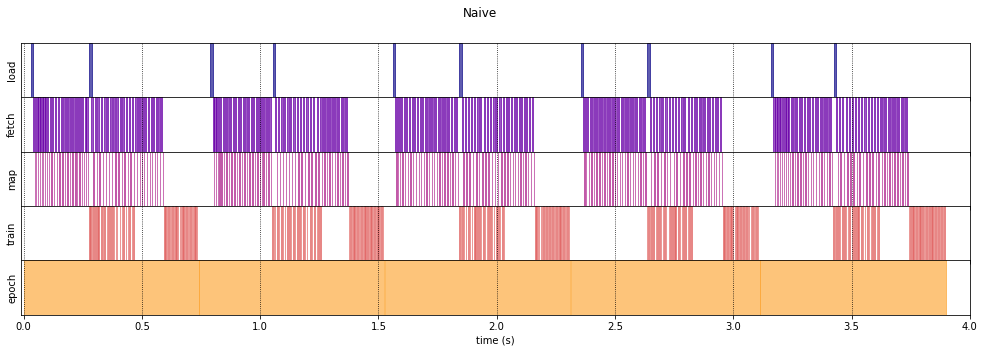

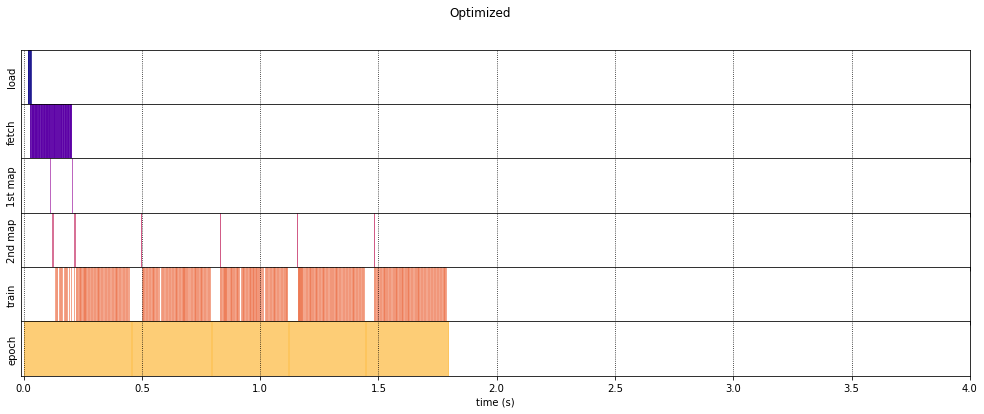

In [26]:
draw_timeline(naive_timeline, "Naive", 4, False)
draw_timeline(optimized_timeline, "Optimized", 4, False)